In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from utils_rdkit import  get_data_for_target, plot_results
from sklearn_utils import DataSet, grid_search


# Set pandas to display all rows
pd.set_option('display.max_rows', None)

#### Example - generating LogExtCoeff estimator

##### Getting the data

In [2]:
lec, features = get_data_for_target("LogExtCoeff", replace_na_value=None)
print(f'LEC shape: {lec.shape}')
print(f'Features shape: {features.shape}')
features.describe().T

LEC shape: (8041,)
Features shape: (8041, 209)


,count,mean,std,min,25%,50%,75%,max
MaxAbsEStateIndex,8041.0,10.825517,4.369425,0.000000,7.074658,1.199140e+01,1.365126e+01,20.888952
MaxEStateIndex,8041.0,10.825517,4.369425,0.000000,7.074658,1.199140e+01,1.365126e+01,20.888952
MinAbsEStateIndex,8041.0,0.361925,0.348884,0.000000,0.083865,2.264159e-01,5.768239e-01,4.000000
MinEStateIndex,8041.0,-1.166811,1.993234,-8.681424,-3.266609,-4.025322e-01,1.998658e-01,4.000000
qed,8041.0,0.385676,0.235010,0.015606,0.176007,3.563036e-01,5.802481e-01,0.941304
MolWt,8041.0,477.836884,253.492493,16.042999,321.139008,4.124930e+02,5.586780e+02,2052.521973
HeavyAtomMolWt,8041.0,451.458405,235.203232,12.011000,304.354004,3.931220e+02,5.283980e+02,1881.864990
ExactMolWt,8041.0,477.438965,253.283188,16.031300,321.045959,4.121554e+02,5.582267e+02,2050.871338
NumValenceElectrons,8041.0,174.565720,96.489334,8.000000,116.000000,1.500000e+02,2.060000e+02,840.000000
NumRadicalElectrons,8041.0,0.001119,0.033439,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000


It seems the `Ipc` calculated descriptor is bad - getting NaN and inf values.  Lets remove

In [4]:
# Remove 'Ipc' feature
features = features.drop(columns=['Ipc'])

# rows with NaN values
bad_rows = lec[features.isna().any(axis=1)]
bad_rows

3219     5.018700
3220     4.884229
7324     4.322219
7325     4.447158
7548     4.634477
8497     4.610000
8499     4.330000
8501     3.870000
8503     3.840000
8505     4.120000
10773    3.950997
10774    3.941760
10775    3.968903
10776    3.994449
10777    3.973266
10778    3.994449
10779    3.998608
10780    3.998608
10781    3.977586
10782    3.977586
11570    4.420000
20076    4.630000
Name: LogExtCoeff, dtype: float64

Only a small number of rows where `RDKit` was unable to calculate values for all descriptors.  Given low impact on training size - drop them. Droping from all for now to simplify - should really drop just from training set and then have to come up with a replacement strategy for missing values in the prediction function (mean or mode).

In [5]:
# Remove rows with NaN values
lec = lec.drop(bad_rows.index)
features = features.drop(bad_rows.index)

In [6]:
data = DataSet.from_data("LogExtCoeff", features, lec)

In [59]:
print(f'Number of samples: {data.n_samples}')
print(f'Number of features: {data.n_features}')
print(f'Number of training samples: {data.n_train}')
print(f'Number of test samples: {data.n_test}')
print(f'Training ratio: {data.train_ratio:.2f}')
print(f'Test ratio: {data.test_ratio:.2f}')
print(f'Feature names: {data.feature_names}')
print(f'Type of X_train: {type(data.X_train)}')
print(f'Type of y_train: {type(data.y_train)}')

Number of samples: 8019
Number of features: 208
Number of training samples: 6415
Number of test samples: 1604
Training ratio: 0.80
Test ratio: 0.20
Feature names: Index(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons', 'NumRadicalElectrons',
       ...
       'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene',
       'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=208)
Type of X_train: <class 'pandas.core.frame.DataFrame'>
Type of y_train: <class 'pandas.core.series.Series'>


In [7]:
# Example of a gridg search of a RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
params = {
    'n_estimators': [ 200 ],
    'max_depth': [ 20 ],
}

grid, y_pred, r2 = grid_search(rf, params, data, scaler=None, save=True, verbose=3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5] END ....max_depth=20, n_estimators=200;, score=0.791 total time=  43.2s
[CV 2/5] END ....max_depth=20, n_estimators=200;, score=0.827 total time=  43.3s
[CV 4/5] END ....max_depth=20, n_estimators=200;, score=0.790 total time=  43.3s
[CV 3/5] END ....max_depth=20, n_estimators=200;, score=0.764 total time=  43.4s
[CV 1/5] END ....max_depth=20, n_estimators=200;, score=0.734 total time=  43.4s
Best estimator score: 0.7809993994893701
Best params: {'max_depth': 20, 'n_estimators': 200}
Test R2 score: 0.8090879207518678


In [8]:
print(type(r2))


<class 'numpy.float64'>


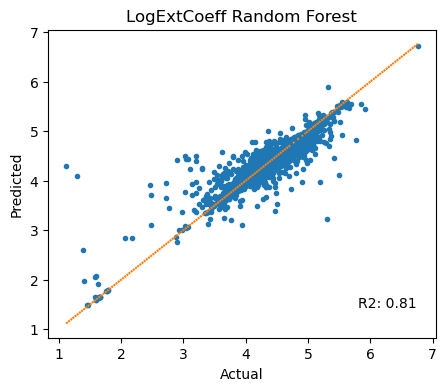

In [11]:

#Plot the results
plot_results(data.y_test, y_pred, 'LogExtCoeff Random Forest', r2)

In [104]:
# Example of search for best Ridge Regression model
estimator = Ridge(random_state=42)
scaler =  StandardScaler()
params = {
    'alpha': [0.2],
    'max_iter': [100]
}

grid = grid_search(estimator, params, data, scaler=scaler, save=False, verbose=3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 3/5] END .est__alpha=0.2, est__max_iter=100;, score=0.449 total time=   0.0s
[CV 1/5] END .est__alpha=0.2, est__max_iter=100;, score=0.464 total time=   0.0s
[CV 2/5] END .est__alpha=0.2, est__max_iter=100;, score=0.566 total time=   0.0s
[CV 4/5] END .est__alpha=0.2, est__max_iter=100;, score=0.466 total time=   0.0s
[CV 5/5] END .est__alpha=0.2, est__max_iter=100;, score=0.524 total time=   0.0s
Best estimator score: 0.4939501071150961
Best params: {'est__alpha': 0.2, 'est__max_iter': 100}
Test R2 score: 0.5165252418330682
